In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from iminuit import Minuit
from astropy.io import fits
from matplotlib.colors import LogNorm
from sklearn.linear_model import LinearRegression

In [2]:
sns.set_style('ticks')
sns.set_context('notebook')

In [6]:
TAIL_DIR = '/global/'

In [7]:
def nmad(arr):
    med = np.nanmedian(arr)
    mad = np.nanmedian(np.abs(arr-med))
    return 1.4826 * mad

   
def fit_cte(tails, channel, amp, serial, return_all=False):
    if tails[channel][amp] == {}:
        return np.nan
    peak_vals, locs, tail_counts = [], [], []
    for k, v in tails[channel][amp].items():
        if len(v['peak_vals']) == 0:
            continue
        peak_vals.append(v['peak_vals'])
        if serial:
            locs.append(v['loc_x'].values)
            tail_counts.append(v['tails_serial'][:, :4])
        else:
            locs.append(v['loc_y'].values)
            tail_counts.append(v['tails_parallel'][:, :4])
    if len(peak_vals) == 0:
        return np.nan
    peak_vals = np.concatenate(peak_vals)
    locs = np.concatenate(locs)
    tail_counts = np.sum(np.concatenate(tail_counts), axis=1)
    
    if serial:
        bins = np.arange(0, 1050, 64)
    else:
        bins = np.arange(0, 5000, 256)
        
    median = np.array([np.median((tail_counts/peak_vals)[np.where((locs>bins[i]) & (locs<bins[i+1]))]) for i in range(len(bins)-1)])
    nmads = np.array([nmad((tail_counts/peak_vals)[np.where((locs>bins[i]) & (locs<bins[i+1]))]) for i in range(len(bins)-1)])
    cts = np.array([len((tail_counts/peak_vals)[np.where((locs>bins[i]) & (locs<bins[i+1]))]) for i in range(len(bins)-1)])
    bins = (bins[1:]+bins[:-1])/2.
    nan_cut = cts==0
    median = median[~nan_cut]
    nmads = nmads[~nan_cut]/cts[~nan_cut]
    bins = bins[~nan_cut]
    
    def chisq(m, b):
        line = m * bins + b
        diff = median - line
        return np.sum(diff**2/nmads**2)
    
    m = Minuit(chisq, pedantic=False, print_level=0,
               m=1e-6, b=0,
               limit_m=(-1, 1), limit_b=(-1, 1))
    m.migrad()
    if return_all:
        return m.values
    return m.values['m']

def cte_plot(tails, channel, amp, serial):
    peak_vals = np.concatenate([v['peak_vals'] for k, v in tails[channel][amp].items()])
    if serial:
        locs = np.concatenate([v['loc_x'] for k, v in tails[channel][amp].items()])
        tail_counts = np.sum(np.concatenate([v['tails_serial'][:, :4] for k, v in tails[channel][amp].items()]), axis=1)
    else:
        locs = np.concatenate([v['loc_y'] for k, v in tails[channel][amp].items()])
        tail_counts = np.sum(np.concatenate([v['tails_parallel'][:, :4] for k, v in tails[channel][amp].items()]), axis=1)
    plt.scatter(locs, tail_counts/peak_vals, s=1, alpha=0.2)
    if serial:
        bins = np.arange(0, 1050, 64)
    else:
        bins = np.arange(0, 5000, 256)
    median = [np.median((tail_counts/peak_vals)[np.where((locs>bins[i]) & (locs<bins[i+1]))]) for i in range(len(bins)-1)]
    nmads = [nmad((tail_counts/peak_vals)[np.where((locs>bins[i]) & (locs<bins[i+1]))]) for i in range(len(bins)-1)]
    plt.errorbar((bins[1:]+bins[:-1])/2, median,
                 xerr=(bins[1:]-bins[:-1])/2-1, yerr=nmads,
                 color='C3', linewidth=0, elinewidth=1, marker='o', alpha=0.9, label='Binned median')
    m = fit_cte(tails, channel, amp, serial, return_all=True)
    plt.plot(bins, m['m']*bins + m['b'], linewidth=2, color='k', label='y = {:0.2e}x + {:0.2e}'.format(m['m'], m['b']))
    if serial:
        plt.xlim(0, 1024)
    else:
        plt.xlim(0, 4096)
    plt.ylim(-1, 1)
    if serial:
        plt.xlabel('Y-position')
    else:
        plt.xlabel('Y-position')
    plt.ylabel('Counts in trail/peak counts')
    plt.legend()

In [8]:
os.listdir(TAIL_DIR)[1]

FileNotFoundError: [Errno 2] No such file or directory: '/global/cscratch1/sd/sdixon/cte_tails/'

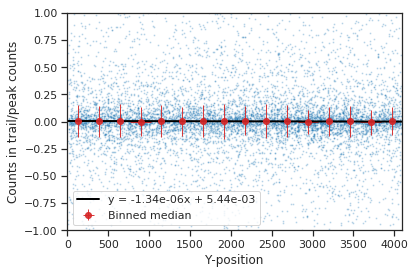

In [266]:
tails = pickle.load(open(os.path.join(TAIL_DIR, '11_066_serial.pkl'), 'rb'))
cte_plot(tails, 'B', 0, serial)

In [23]:
cte_measurements = []
for f in tqdm(sorted(os.listdir(TAIL_DIR))):
    path = os.path.join(TAIL_DIR, f)
    year, night, _ = f.split('.')[0].split('_')
    tails = pickle.load(open(path, 'rb'))
    night_data = {'year': int(year), 'night': int(night)}
    for channel in tails.keys():
        for amp in tails[channel].keys():
            for serial in (True, False):
                key = '{}_{}'.format(channel, amp)
                key = key + 'S' if serial else key + 'P'
                cte = fit_cte(tails, channel, amp, serial=serial)
                night_data[key] = cte
    cte_measurements.append(night_data)

  0%|          | 0/1672 [00:00<?, ?it/s]/global/homes/s/sdixon/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide
/global/homes/s/sdixon/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    m = +nan
    b = +0.000000

/global/homes/s/sdixon/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    m = +0.000001
    b = +nan

/global/homes/s/sdixon/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    m = +nan
    b = +nan

100%|██████████| 1672/1672 [02:39<00:00, 15.73it/s]


In [24]:
df = pd.DataFrame(cte_measurements)
df.head()

,B_0P,B_0S,B_1P,B_1S,P_0P,P_0S,P_1P,P_1S,P_2P,P_2S,P_3P,P_3S,R_0P,R_0S,R_1P,R_1S,night,year
0,-0.000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,195,4
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205,4
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,211,4
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,215,4
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,226,4


In [115]:
df['dt'] = pd.to_datetime(2000000 + df.year*1000 + df.night, format='%Y%j')
df['date'] = 2000 + df.year + df.night/365

In [215]:
df.to_csv('cte_from_dark_frames.csv')

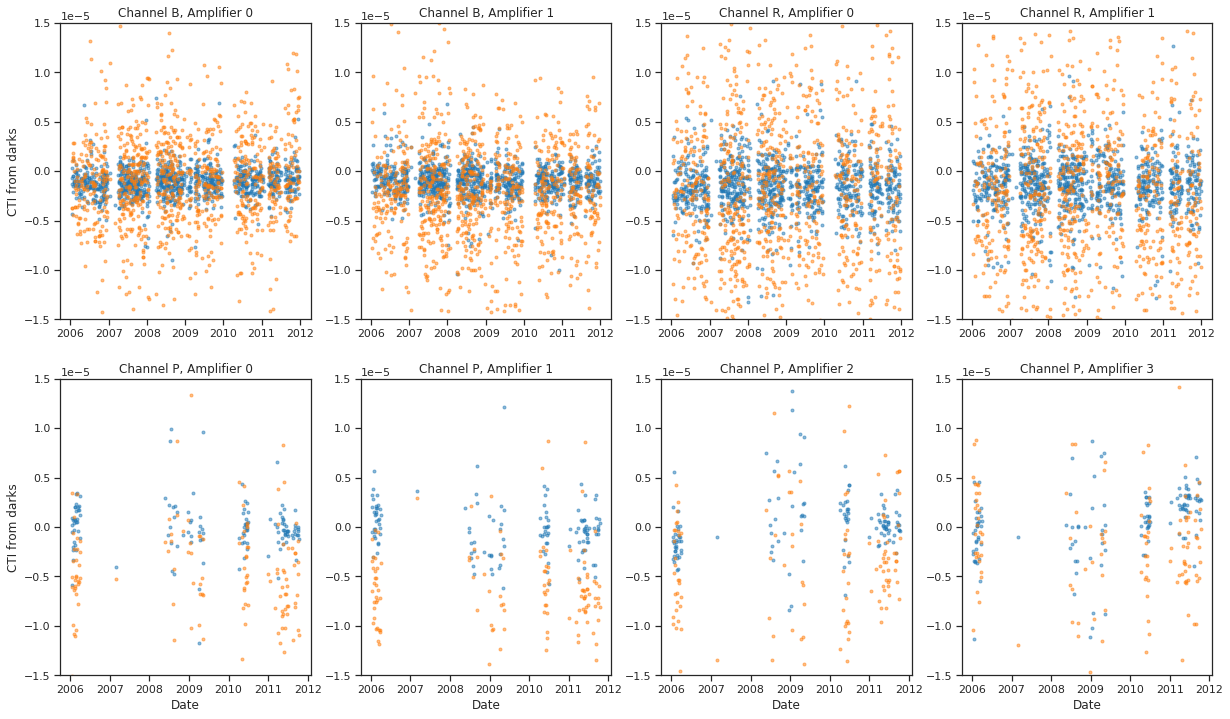

In [200]:
plt.figure(figsize=(16, 12))
for i, column in enumerate(['B_0', 'B_1', 'R_0', 'R_1', 'P_0', 'P_1', 'P_2', 'P_3']):
    plt.subplot(2, 4, i+1)
    xdt = df[df.year>5].date.astype(float)
    y_parallel = df[df.year>5][column+'P']
    y_serial = df[df.year>5][column+'S']
    mask = np.isnan(y_parallel) | np.isnan(y_serial)
    xdt = xdt[~mask]
    y_parallel = y_parallel[~mask]
    y_serial = y_serial[~mask]
    plt.plot(xdt, y_parallel, '.', label='Parallel', alpha=0.5)
    plt.plot(xdt, y_serial, '.', label='Serial', alpha=0.5)
    plt.ylim(-1.5e-5, 1.5e-5)
    if i > 3:
        plt.xlabel('Date')
    if i % 4 == 0:
        plt.ylabel('CTI from darks')
    plt.subplots_adjust(left=-0.1)
    plt.title('Channel {}, Amplifier {}'.format(*column.split('_')))
    plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.savefig('figures/time_variation.png', bbox_inches='tight')

In [216]:
def fit_line(x, y):
    x = x - np.median(x)
    
    def chisq(m, b):
        line = m * x + b
        diff = y - line
        return np.sum(diff**2)
    
    m = Minuit(chisq, pedantic=False, print_level=0,
               m=0, b=np.median(y))
    m.migrad()
    m.hesse()
    return m

In [217]:
for i, column in enumerate(['B_0', 'B_1', 'R_0', 'R_1', 'P_0', 'P_1', 'P_2', 'P_3']):
    xdt = df[df.year>5].date.astype(float)
    y_parallel = df[df.year>5][column+'P']
    y_serial = df[df.year>5][column+'S']
    mask = np.isnan(y_parallel) | np.isnan(y_serial)
    xdt = xdt[~mask]
    y_parallel = y_parallel[~mask]
    y_serial = y_serial[~mask]

    fit_parallel = fit_line(xdt.values, y_parallel.values)
    fit_serial = fit_line(xdt.values, y_serial.values)
    
    print('Camera {}, Amp. {}, Parallel change in CTI per year'.format(column[0], column[-1]))
    print('{:0.3e} +/- {:0.3e}'.format(fit_parallel.values['m'], fit_parallel.errors['m']))
    print(fit_parallel.values['b'], fit_parallel.errors['b'])
    print('Camera {}, Amp. {}, Serial change in CTI per year'.format(column[0], column[-1]))
    print('{:0.3e} +/- {:0.3e}'.format(fit_serial.values['m'], fit_serial.errors['m']))
    print(fit_serial.values['b'], fit_serial.errors['b'])
    print()

Camera B, Amp. 0, Parallel change in CTI per year
8.110e-08 +/- 1.810e-02
-1.0907872004740686e-06 0.030448638198609917
Camera B, Amp. 0, Serial change in CTI per year
2.203e-07 +/- 1.810e-02
-8.906657218649198e-07 0.03044863819860992

Camera B, Amp. 1, Parallel change in CTI per year
-7.911e-08 +/- 1.810e-02
-1.0249643981985477e-06 0.030448638198609927
Camera B, Amp. 1, Serial change in CTI per year
-8.787e-08 +/- 1.810e-02
-1.8513735754079066e-06 0.03044863819860992

Camera R, Amp. 0, Parallel change in CTI per year
-2.364e-08 +/- 1.811e-02
-1.5107733288643423e-06 0.03063514502783882
Camera R, Amp. 0, Serial change in CTI per year
2.539e-07 +/- 1.811e-02
-1.9145069583671516e-06 0.030635145027838814

Camera R, Amp. 1, Parallel change in CTI per year
9.360e-09 +/- 1.811e-02
-1.3804241673720834e-06 0.03063514502783882
Camera R, Amp. 1, Serial change in CTI per year
-2.684e-07 +/- 1.811e-02
-2.6244864660783597e-06 0.030635145027838814

Camera P, Amp. 0, Parallel change in CTI per year
-8.

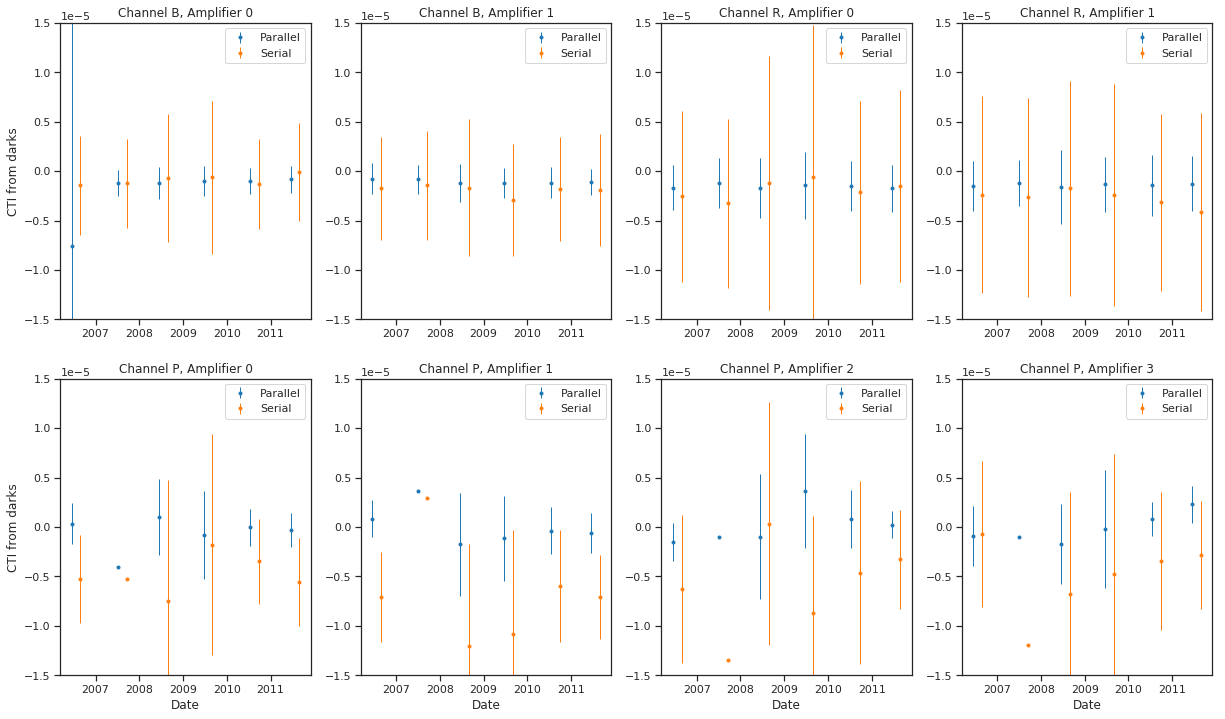

In [258]:
plt.figure(figsize=(16, 12))
late_df = df[df.year > 5]
for i, column in enumerate(['B_0', 'B_1', 'R_0', 'R_1', 'P_0', 'P_1', 'P_2', 'P_3']):
    plt.subplot(2, 4, i+1)
    yearly_mean = late_df.groupby('year').mean()
    yearly_std = late_df.groupby('year').std()
    plt.errorbar(yearly_mean.date-0.1, yearly_mean[column + 'P'], yearly_std[column + 'P'],
                 marker='.', linewidth=0, elinewidth=1, label='Parallel')
    plt.errorbar(yearly_mean.date+0.1, yearly_mean[column + 'S'], yearly_std[column + 'S'],
                 marker='.', linewidth=0, elinewidth=1, label='Serial')
    plt.ylim(-1.5e-5, 1.5e-5)
    plt.legend()
    if i > 3:
        plt.xlabel('Date')
    if i % 4 == 0:
        plt.ylabel('CTI from darks')
    plt.subplots_adjust(left=-0.1)
    plt.title('Channel {}, Amplifier {}'.format(*column.split('_')))
    plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.savefig('figures/time_variation_by_year.png', bbox_inches='tight')